In [1]:
import random
import os
import glob
import time
import shutil
import itertools
import cv2


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import class_weight

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB4

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import class_weight




2024-05-20 15:47:13.074439: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 15:47:13.074583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 15:47:13.206914: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train = pd.read_csv('/kaggle/input/completed-dataset/train_data.csv')
val = pd.read_csv('/kaggle/input/completed-dataset/val_data.csv')
test = pd.read_csv('/kaggle/input/completed-dataset/test_data.csv')

In [3]:
train = train.drop('path_dicom', axis=1)
val = val.drop('path_dicom', axis=1)
test = test.drop('path_dicom', axis=1)

In [4]:
def normalize_col(df, col):
    normalized_columns = normalize(df[col])

    for i, col in enumerate(col):
        df[col] = normalized_columns[:, i]
    
    return df

cols = ['age_approx', 'sex', 'anatom_site_general_challenge']
train = normalize_col(train, cols)
val = normalize_col(val, cols)
test = normalize_col(test, cols)

In [5]:
class CFG:
    EPOCHS = 10
    BATCH_SIZE = 32
    SEED = 42
    TF_SEED = 768
    WIDTH = 224
    HEIGHT = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)

In [6]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train['diagnosis']),
    y=train['diagnosis']
)
class_weights_dict = dict(enumerate(class_weights))

In [7]:
def hair_remove(image):
    # convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1, (17, 17))
    
    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    
    # apply thresholding to blackhat
    _, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    
    # inpaint with original image and threshold image
    final_image = cv2.inpaint(image, threshold, 1, cv2.INPAINT_TELEA)
    
    return final_image

In [8]:
def load_image(image_path):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    
    # Resize image
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH],
                            method=tf.image.ResizeMethod.LANCZOS3)
    
    image_uint8 = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    
    image_uint8 = tf.numpy_function(hair_remove, [image_uint8], tf.uint8)
    # Convert image dtype to float32 and NORMALIZE!!!
    image = tf.cast(image, tf.float32)/255.
    
    # Return image
    return image

In [9]:
augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=CFG.TF_SEED),
], name='augmentation_layer')

In [10]:
def encode_labels(labels, encode_depth=4):
    return tf.one_hot(labels, depth=encode_depth)

In [11]:
def create_pipeline(df, load_function, augment=False, batch_size=32, shuffle=False, cache=None, prefetch=False):
    image_paths = df.path_jpeg
    image_labels = encode_labels(df.diagnosis)
    AUTOTUNE = tf.data.AUTOTUNE
    
    ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
    
    if augment:
        ds = ds.map(lambda x, y: (augmentation_layer(load_function(x)), y))
    else:
        ds = ds.map(lambda x, y: (load_function(x), y))
    
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        
    ds = ds.batch(batch_size)
    
    if cache is not None:
        ds = ds.cache(cache)
    
    if prefetch:
        ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    # Return the dataset
    return ds

In [12]:
train_ds = create_pipeline(train, load_image, augment=True, 
                           batch_size=CFG.BATCH_SIZE, 
                           shuffle=False, prefetch=True)

val_ds = create_pipeline(val, load_image, 
                         batch_size=CFG.BATCH_SIZE, 
                         shuffle=False, prefetch=False)

test_ds = create_pipeline(test, load_image, 
                          batch_size=CFG.BATCH_SIZE, 
                          shuffle=False, prefetch=False)

In [13]:
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')
print('Test Input Data Pipeline:\n\n', test_ds)
print('========================================')

Train Input Data Pipeline:

 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
Validation Input Data Pipeline:

 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
Test Input Data Pipeline:

 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


In [14]:
def build_DenseNet121_model(input_shape=CFG.IMAGE_SIZE, base_weights='imagenet', num_classes=4):
    base_model = DenseNet121(weights=base_weights, include_top=False, input_shape=input_shape)
    
    for layer in base_model.layers:
        layer.trainable = True

    x = base_model.output
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    tl_model = Model(inputs=base_model.input, outputs=x)
    
    return tl_model

In [15]:
DenseNet121_model = build_DenseNet121_model()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
DenseNet121_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 13,460,676 (51.35 MB)

 Trainable params: 13,377,028 (51.03 MB)

 Non-trainable params: 83,648 (326.75 KB)

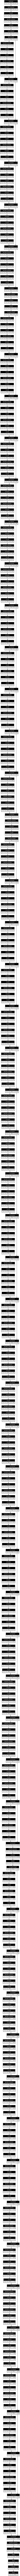

In [17]:
plot_model(
    DenseNet121_model, dpi=60,
    show_shapes=True
)

In [18]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, 
                tf_valid_data=None, shuffling=False, class_weight=None):
    '''
        Trains a TensorFlow model and returns a dict object containing the model metrics history data. 
        
        @params
        - model: (tf.keras.model) -> model to be trained 
        - num_epochs: (int) -> number of epochs to train the model
        - callbacks_list: (list) -> list containing callback fuctions for model
        - tf_train_data: (tf.data.Dataset) -> dataset for model to be train on 
        - tf_valid_data: (tf.data.Dataset) -> dataset for model to be validated on (default=None)
        - shuffling: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        
        @returns
        - model_history: (dict) -> dictionary containing loss and metrics values tracked during training
    '''
    
    model_history = {}
    
    if not tf_valid_data:
        validation_data = None
        validation_steps = None
    else:
        validation_data = tf_valid_data
        validation_steps = int(len(tf_valid_data))
        
    model_history = model.fit(tf_train_data,
                              epochs=num_epochs,
                              validation_data=validation_data,
                              validation_steps=validation_steps,
                              callbacks=callbacks_list,
                              shuffle=shuffling,
                             class_weight=class_weight)
        
    return model_history

In [19]:
optimizer = Adam(0.0001)
DenseNet121_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [20]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, mode='max', min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_model_dn121.keras', save_best_only=True, monitor='val_accuracy', verbose=1)

callback_list = [model_chkpt, lr_reduce, early_stop]

In [32]:
print(f'Training {DenseNet121_model.name}.')
print(f'Train on {len(train)} samples, validate on {len(val)} samples.')
print('----------------------------------')

DenseNet121_model_history = train_model(
    DenseNet121_model, CFG.EPOCHS, callback_list, 
    train_ds, val_ds,
    shuffling=False,class_weight=class_weights_dict 
)

Training functional_2.
Train on 26160 samples, validate on 4905 samples.
----------------------------------
Epoch 1/10
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7180 - loss: 0.8927
Epoch 1: val_accuracy improved from 0.73211 to 0.83282, saving model to best_model_dn121.keras
818/818 ━━━━━━━━━━━━━━━━━━━━ 2606s 3s/step - accuracy: 0.7180 - loss: 0.8928 - val_accuracy: 0.8328 - val_loss: 0.5804 - learning_rate: 1.0000e-04
Epoch 2/10
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7571 - loss: 0.8538
Epoch 2: val_accuracy did not improve from 0.83282
818/818 ━━━━━━━━━━━━━━━━━━━━ 2232s 3s/step - accuracy: 0.7570 - loss: 0.8539 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2: early stopping


<Axes: >

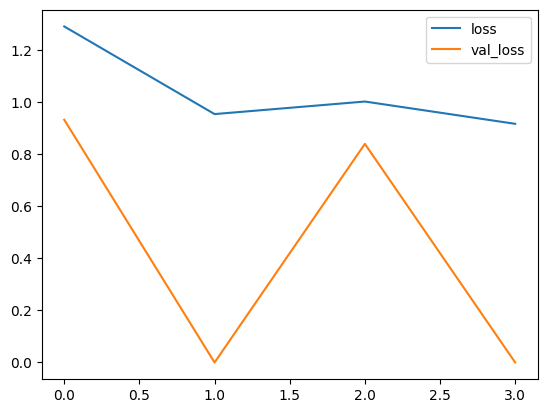

In [22]:
metrics = pd.DataFrame(DenseNet121_model.history.history)
metrics[["loss","val_loss"]].plot()

In [23]:
DenseNet121_model_eval = DenseNet121_model.evaluate(test_ds)

52/52 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.7764 - loss: 0.6666


W0000 00:00:1716231198.482403     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [24]:
DenseNet121_test_probabilities = DenseNet121_model.predict(test_ds, verbose=1)
DenseNet121_test_predictions = tf.argmax(DenseNet121_test_probabilities, axis=1)

 2/52 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step  

W0000 00:00:1716231251.519603     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


52/52 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step


W0000 00:00:1716231378.414974     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [25]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12): 
    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=1, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0) 

    # Plot confusion matrix
    plt.show()
    
    return

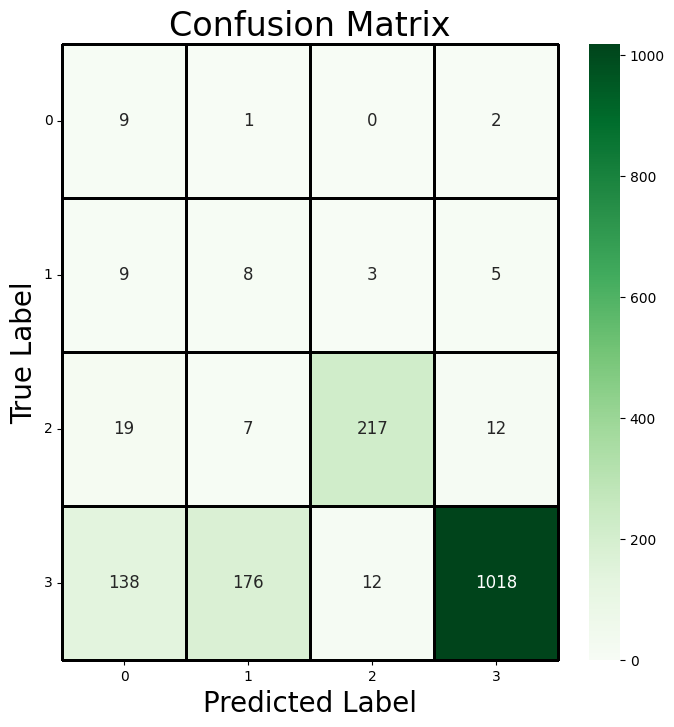

In [26]:
class_names = ['0', '1', '2', '3']

plot_confusion_matrix(
    test.diagnosis, 
    DenseNet121_test_predictions, 
    figsize=(8, 8),  
    classes=class_names)

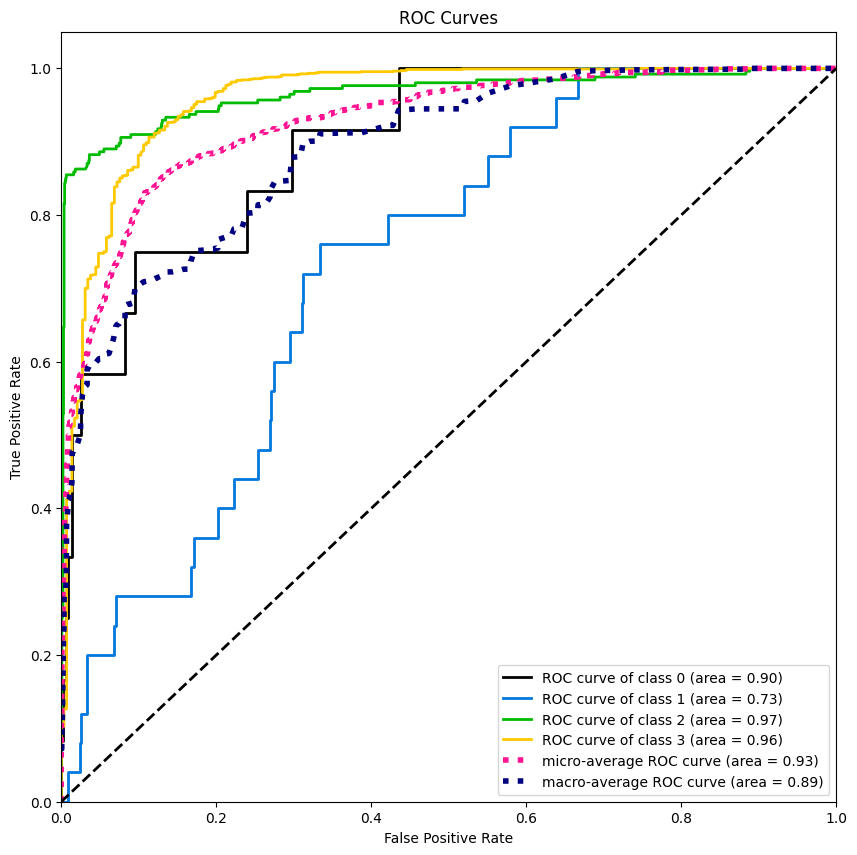

In [27]:
plot_roc(test.diagnosis, 
         DenseNet121_test_probabilities, 
         figsize=(10, 10), title_fontsize='large');

In [28]:
print(classification_report(test.diagnosis, 
                            DenseNet121_test_predictions, 
                            target_names=class_names))

              precision    recall  f1-score   support

           0       0.05      0.75      0.10        12
           1       0.04      0.32      0.07        25
           2       0.94      0.85      0.89       255
           3       0.98      0.76      0.86      1344

    accuracy                           0.77      1636
   macro avg       0.50      0.67      0.48      1636
weighted avg       0.95      0.77      0.84      1636



In [29]:
def plot_training_curves(history):
    
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

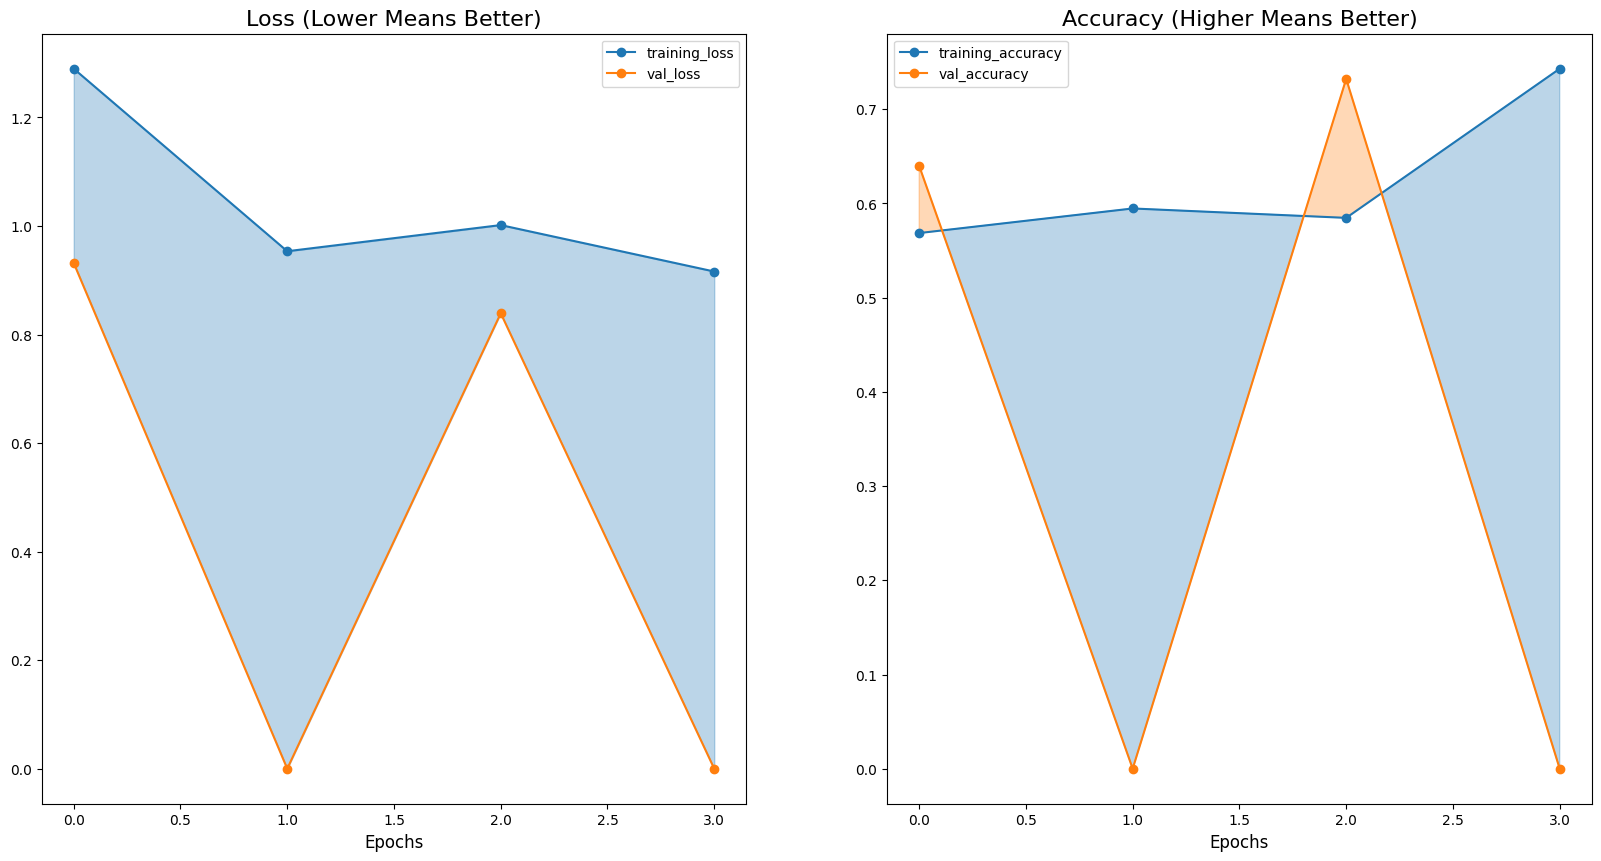

In [30]:
plot_training_curves(DenseNet121_model_history)